<div>
    <div style="float:left;width:50%;text-align:center">
        <h1>pyGIMLi Tutorial @ Transform 2021</h1>
        <div>
<table style="border-collapse:collapse;border-color:#ccc;border-spacing:0" class="tg"><thead><tr><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal"></th><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Info</th></tr></thead><tbody><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">When</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Monday, April 19 • 8:00 - 10:00 UTC (starts at 10.00 a.m. CET)</td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Slack (Q&amp;A)</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://softwareunderground.org/">Software Underground</a> channel <a href="https://swung.slack.com/archives/C01T5V5S9EV">#t21-mon-pygimli</a></td></tr><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Live stream</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://youtu.be/w3pu0H3dXe8">https://youtu.be/w3pu0H3dXe8</a></td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">pyGIMLi documentation</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://www.pygimli.org/documentation.html">https://www.pygimli.org/documentation.html</a></td></tr></tbody></table>
        </div>
    </div>
    <div style="float:right;width:30%">
        <img src="https://www.pygimli.org/_images/pg_logo.png" alt="pyGIMLi logo">
    </div>
</div>

# Inversion settings: Inverting electrical resistivity field data

In [20]:
# Just some plotting settings
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
%config InlineBackend.figure_format='svg' # Setting figure format for this notebook

In [21]:
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert  # the module

We first load a sample data file, which was measured on the beach of Borkum island in the North sea.

In [22]:
data = ert.load("data/beach.ohm")
print(data)

Data: Sensors: 81 data: 1478, nonzero entries: ['a', 'b', 'i', 'm', 'n', 'r', 'u', 'valid']


The data set obviously has, besides current and potential indices, voltage and current.

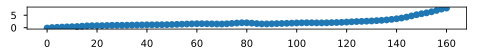

In [23]:
fig, ax = plt.subplots()
ax.plot(pg.x(data), pg.z(data), 'o-')
ax.set_aspect(1.0)

There is some topography present in the data set which affects the geometric factor.

We need a geometric factor to convert them into apparent resistivities. It is calculated numerically, i.e. by a refined mesh with quadratic shape functions. Note that repeated calls do not cost runtime as the result is cached.

In [24]:
data['k'] = ert.createGeometricFactors(data, numerical=True)

18/04/21 - 20:55:10 - pyGIMLi - INFO - Cache c:\msys64\home\halbm\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (19.2s x 6): C:\Users\halbm\AppData\Roaming\pygimli\Cache\14443359716248028795


Additionally we compute an analytical geometric factor based on a flat-earth assumption. We are going to show the geometric effec, i.e. the ratio of both geometric factors (Rücker et al. 2006).

18/04/21 - 20:55:20 - pyGIMLi - INFO - Cache c:\msys64\home\halbm\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 7): C:\Users\halbm\AppData\Roaming\pygimli\Cache\12892129349996102566


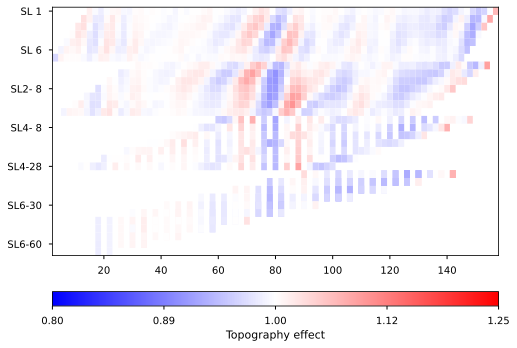

In [25]:
k0 = ert.createGeometricFactors(data)
ert.show(data, vals=k0/data['k'], label='Topography effect',
        cMap="bwr", cMin=0.8, cMax=1.25, logScale=True);

For inversion, we need an error estimate, i.e. retrieved from reciprocal analysis. Errors usually consist of a relative error and an absolute error (voltage gain). Here we assume typical values of 3% and 50µV.

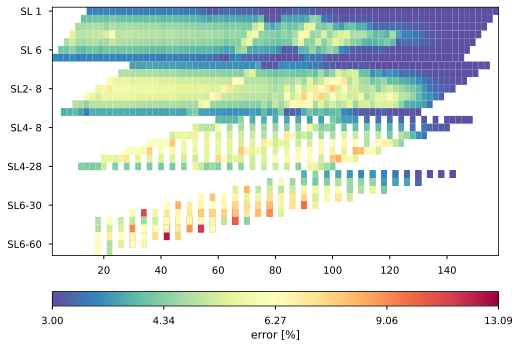

In [28]:
data['err'] = ert.estimateError(data, 
                                absoluteUError=0.00005, # 50µV
                                relativeError=0.03)  # 3%
ert.show(data, data['err']*100, label="error [%]");

In [29]:
mgr = ert.ERTManager(data)
mgr.invert(verbose=True,
           #paraDX=0.3, paraMaxCellSize=10, paraDepth=20, quality=34,
           lam=50, 
           zWeight=0.3,
          )

18/04/21 - 20:58:10 - pyGIMLi - INFO - Found 2 regions.
18/04/21 - 20:58:10 - pyGIMLi - INFO - Region with smallest marker (1) set to background
18/04/21 - 20:58:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/04/21 - 20:58:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/04/21 - 20:58:10 - pyGIMLi - INFO - Starting inversion.
18/04/21 - 20:58:10 - pyGIMLi - INFO - Set default startmodel to median(data values)=4.107299820625489
18/04/21 - 20:58:10 - pyGIMLi - INFO - Created startmodel from forward operator: 1294 [4.107299820625489,...,4.107299820625489]


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000028674F5A810>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000028674F5ACC0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000028632224400>
min/max (data): 1.00/2067
min/max (error): 3.00%/13.09%
min/max (start model): 4.11/4.11
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 140.76 (dPhi = 63.43%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 42.03 (dPhi = 68.83%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 9.91 (dPhi = 70.07%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 5.9 (dPhi = 31.56%) lam: 50.0
------------------------------

1294 [1671.78723429734,...,22.97379177640937]

The chi-squared fit is not quite 1 but not far away from it, so we want to have a look at the model.

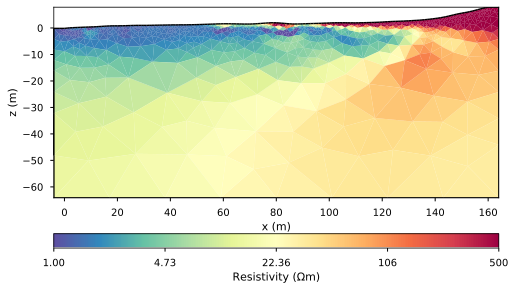

In [30]:
mgr.showResult(cMin=1, cMax=500, xlabel="x (m)", ylabel="z (m)");

It shows high resistivities in the dune area and low resistivity (salt or brackish water) towards the beach. From the dune, freshwater is moving towards the sea. We want to have a look at the measured and modelled data.

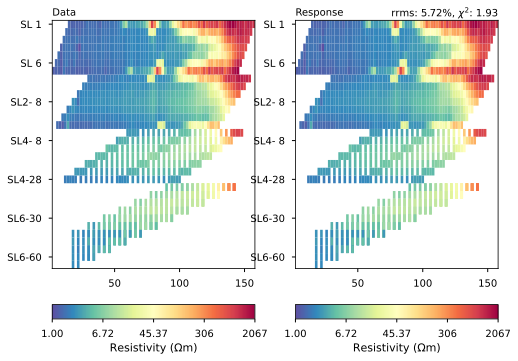

In [31]:
mgr.showFit();

Alternatively, we might look at the misfit distribution to see whether it is uncorrelated Gaussian.

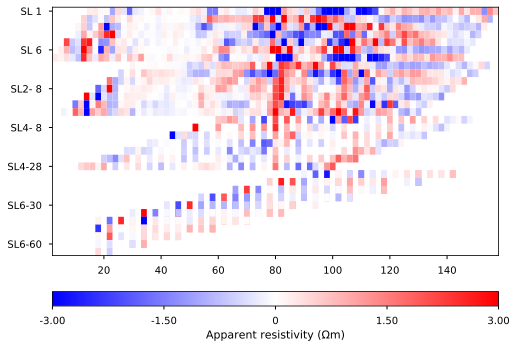

In [32]:
misfit = pg.log(mgr.inv.response / mgr.data["rhoa"]) / data["err"]
pg.show(data, misfit, cMap="bwr", cMin=-3, cMax=3);

A good and simple resolution measure is the coverage, i.e. sum of sensitivities.

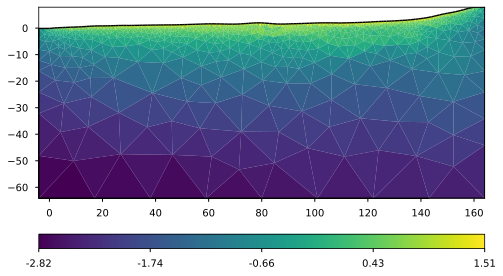

In [33]:
pg.show(mgr.paraDomain, mgr.coverage());

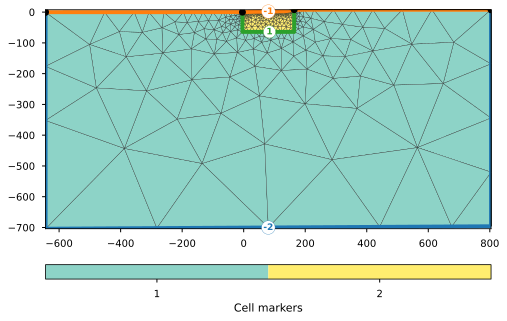

In [34]:
# Let's have a look at the actual mesh behind the inversion
ax, _ = pg.show(mgr.mesh, markers=True, showMesh=True);
# ax.set_xlim(-20, 180);
# ax.set_ylim(-40, 5);

Now we want to create our own mesh and include a known structural boundary as prior information.

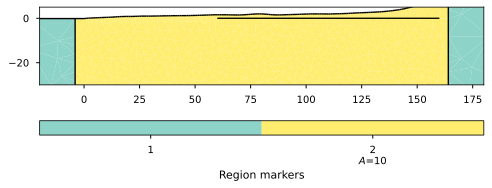

In [36]:
geo = pg.meshtools.createParaMeshPLC(data, paraMaxCellSize=10)
line = pg.meshtools.createLine(start=[60, 0], end=[160, 0], marker=1)
geo += line
ax, _ = pg.show(geo);
ax.set_xlim(-20, 180);
ax.set_ylim(-30, 5);

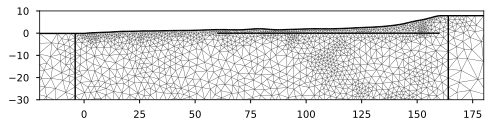

In [39]:
mesh = pg.meshtools.createMesh(geo, quality=34.3)
ax, _ = pg.show(mesh)
ax.set_ylim(-30, 10)
ax.set_xlim(-20, 180);

18/04/21 - 21:03:58 - pyGIMLi - INFO - Found 2 regions.
18/04/21 - 21:03:58 - pyGIMLi - INFO - Region with smallest marker (1) set to background
18/04/21 - 21:03:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/04/21 - 21:03:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/04/21 - 21:03:58 - pyGIMLi - INFO - Starting inversion.
18/04/21 - 21:03:58 - pyGIMLi - INFO - Set default startmodel to median(data values)=4.107299820625489
18/04/21 - 21:03:58 - pyGIMLi - INFO - Created startmodel from forward operator: 3768 [4.107299820625489,...,4.107299820625489]


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002867C88AE50>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000028632514F40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000286322B0E50>
min/max (data): 1.00/2067
min/max (error): 3.00%/13.09%
min/max (start model): 4.11/4.11
--------------------------------------------------------------------------------


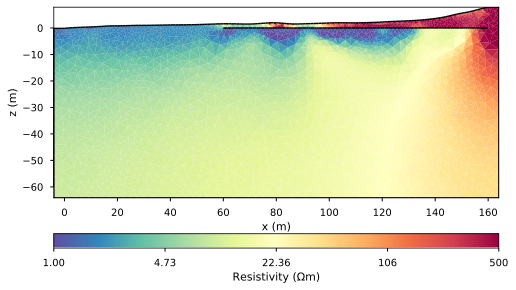

In [40]:
mgrConstrained = ert.ERTManager(data)
mgrConstrained.invert(data=data, verbose=True, lam=50, mesh=mesh, maxIter=3)
mgrConstrained.showResult(cMin=1, cMax=500, xlabel="x (m)", ylabel="z (m)");